In [1]:
# import the used libraries
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import QuantLib as ql
%matplotlib inline

In [62]:
    today = ql.Date(7,4,2015)
    ql.Settings.instance().setEvaluationDate(today)

    # Setup Marketdata
    rate = ql.SimpleQuote(0.03)
    rate_handle = ql.QuoteHandle(rate)
    dc = ql.Actual365Fixed()
    yts = ql.FlatForward(today, rate_handle, dc)
    yts.enableExtrapolation()
    hyts = ql.RelinkableYieldTermStructureHandle(yts)
    t0_curve = ql.YieldTermStructureHandle(yts)
    euribor6m = ql.Euribor6M(hyts)
    cal = ql.TARGET()

    # Setup a dummy portfolio with two Swaps
    def makeSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
        end = ql.TARGET().advance(start, maturity)
        fixedLegTenor = ql.Period("1y")
        fixedLegBDC = ql.ModifiedFollowing
        fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
        spread = 0.0
        fixedSchedule = ql.Schedule(start,end,  fixedLegTenor,   index.fixingCalendar(),   fixedLegBDC,  fixedLegBDC,   ql.DateGeneration.Backward,   False)
        floatSchedule = ql.Schedule(start,  end,  index.tenor(),  index.fixingCalendar(),   index.businessDayConvention(),  index.businessDayConvention(),   ql.DateGeneration.Backward,  False)
        swap = ql.VanillaSwap(typ,  nominal,  fixedSchedule,  fixedRate,  fixedLegDC,  floatSchedule,  index,  spread,  index.dayCounter())
        return swap, [index.fixingDate(x) for x in floatSchedule][:-1]


    def makeSwaption(swap, callDates, settlement):
        if len(callDates) == 1:
            exercise = ql.EuropeanExercise(callDates[0])
        else:
            exercise = ql.BermudanExercise(callDates)
        return ql.Swaption(swap, exercise, settlement)


    settlementDate = today + ql.Period("2D")
    
result = []
change = np.arange(0.01, 0.1, 0.001)

In [65]:
for itr in change:
    swaps = [makeSwap(settlementDate,  ql.Period("5Y"), 1e6,  itr,  euribor6m) ]
    calldates = [ql.Date(7,4,2016), ql.Date(6,4,2017), ql.Date(5,4, 2018), ql.Date(5,4,2019)]
    #swaptions = [makeSwaption(swap,  calldates,  ql.Settlement.Physical)  for swap, fd in swaps]
    calldates = [euribor6m.valueDate(d) for d in calldates]

    engine = ql.DiscountingSwapEngine(hyts)
    for swap, fixingDates in swaps:
        swap.setPricingEngine(engine)
    
    # Assume the model is already calibrated either historical or market implied
    volas = [ql.QuoteHandle(ql.SimpleQuote(0.0075)), ql.QuoteHandle(ql.SimpleQuote(0.0075))]
    meanRev = [ql.QuoteHandle(ql.SimpleQuote(0.002))]
    model = ql.Gsr(t0_curve, [today+100], volas, meanRev, 16.)
    process = model.stateProcess()
    mcDC = yts.dayCounter()

    def timeFromReferenceFactory(daycounter, ref):
        def impl(dat):
            return daycounter.yearFraction(ref, dat)
        return np.vectorize(impl)

    timeFromReference = timeFromReferenceFactory(mcDC, today)

    def getFixedLeg(swap, t):
        fixed_leg = swap.leg(0)
        n = len(fixed_leg)
        fixed_times=[]
        fixed_amounts=[]
        npv = 0
        for i in range(n):
            cf = fixed_leg[i]
            t_i = timeFromReference(cf.date())
            if t_i > t:
                fixed_times.append(t_i)
                fixed_amounts.append(cf.amount())
        return np.array(fixed_times), np.array(fixed_amounts)

    def getFloatingLeg(swap, t):
        float_leg = swap.leg(1)
        n = len(float_leg)
        float_times = []
        float_dcf = []
        accrual_start_time = []
        accrual_end_time = []
        nominals = []
        for i in range(n):
            # convert base classiborstart_idx Cashflow to
            # FloatingRateCoupon
            cf = ql.as_floating_rate_coupon(float_leg[i])
            value_date = cf.referencePeriodStart()
            t_fix_i = timeFromReference(value_date)
            t_i = timeFromReference(cf.date()) 
            if t_fix_i >= t:
                iborIndex = cf.index()
                index_mat = cf.referencePeriodEnd()
                # year fraction
                float_dcf.append(cf.accrualPeriod())
                # calculate the start and end time
                accrual_start_time.append(t_fix_i)
                accrual_end_time.append(timeFromReference(index_mat))
                # payment time
                float_times.append(t_i)
                # nominals 
                nominals.append(cf.nominal())
        return np.array(float_times), np.array(float_dcf), np.array(accrual_start_time), np.array(accrual_end_time), np.array(nominals)
    
    def getFixedFloatingPeriod(swap, t):
        float_leg = swap.leg(1)
        n = len(float_leg)
        for i in range(n):
            cf = ql.as_floating_rate_coupon(float_leg[i])
            value_date = cf.referencePeriodStart()
            t_fix_i = timeFromReference(value_date)
            t_i = timeFromReference(cf.date()) 
            if t_fix_i < t and t < t_i:
                iborIndex = cf.index()         
                index_mat = cf.referencePeriodEnd()
                # year fraction
                float_dcf = cf.accrualPeriod()
                # calculate the start and end time
                accrual_start_time = t_fix_i
                accrual_end_time = timeFromReference(index_mat)
                # payment time
                float_times = t_i
                # nominals 
                nominals = cf.nominal()
                return (float(float_times), float(float_dcf), float(accrual_start_time), float(accrual_end_time), float(nominals))
        return (float(t), 1., float(t), float(t), 0.)

    def swapPathNPV(swap, t, timegrid):
        fixed_times, fixed_amounts = getFixedLeg(swap, t)
        float_times, float_dcf, accrual_start_time, accrual_end_time, nominals = getFloatingLeg(swap, t)
        df_times = np.concatenate([fixed_times,  accrual_start_time, accrual_end_time, float_times])
        df_times = np.unique(df_times)
        # Store indices of fix leg payment times in 
        # the df_times array
        fix_idx = np.in1d(df_times, fixed_times, True)
        fix_idx = fix_idx.nonzero()
        # Indices of the floating leg payment times 
        # in the df_times array
        float_idx = np.in1d(df_times, float_times, True)
        float_idx = float_idx.nonzero()
        # Indices of the accrual start and end time
        # in the df_times array
        accrual_start_idx = np.in1d(df_times, accrual_start_time, True)
        accrual_start_idx = accrual_start_idx.nonzero()
        accrual_end_idx = np.in1d(df_times, accrual_end_time, True)
        accrual_end_idx = accrual_end_idx.nonzero()
        paytime_ffp, float_dcf_ffp, accrual_start_time_ffp, accrual_end_time_ffp, nominals_ffp = getFixedFloatingPeriod(swap, t)
        # Calculate NPV
        def calc(path):
            if len(df_times)==0:
                return 0
            i = np.where(timegrid == t)[0][0]
            x_t = path[i]
            discount = np.vectorize(lambda T: model.zerobond(T, t, x_t))
            dfs = discount(df_times)
            # Calculate fixed leg npv
            fix_leg_npv = np.sum(fixed_amounts * dfs[fix_idx])
            # Estimate the index fixings
            index_fixings = (dfs[accrual_start_idx] / dfs[accrual_end_idx] - 1) 
            index_fixings /= float_dcf
            # Calculate the floating leg npv
            float_leg_npv = np.sum(nominals * index_fixings * float_dcf * dfs[float_idx])
            # Calculate the already fixed accrual period of the floating leg
            t_f = accrual_start_time_ffp
            i = np.where(timegrid == t_f)[0][0]
            x_f = path[i]
            df_e = model.zerobond(accrual_end_time_ffp, t_f, x_f)
            npv_accrualperiod = (1. / df_e - 1) * nominals_ffp * model.zerobond(paytime_ffp, t, x_t)
            # Calculate swap npv
            npv = float_leg_npv + npv_accrualperiod - fix_leg_npv
            return npv
        return calc

    # Convert call date to time
    callTimes = timeFromReference(calldates)

    swap = swaps[0][0]
    npv = swapPathNPV(swap, 0., np.array([0.]))(np.array([0.]))

    def fixingdates(swap):
        leg = swap.leg(1)
        n = len(leg)
        fixing_dates = []
        for i in range(0, n):
            cf = ql.as_floating_rate_coupon(leg[i])
            value_date = cf.referencePeriodStart()
            fixing_dates.append(value_date)
        return fixing_dates

    # Define evaluation grid
    fixing_dates = fixingdates(swap)
    fixing_times = timeFromReference(fixing_dates )

    date_grid = [today + ql.Period(i, ql.Months) for i in range(0,66)] + calldates + fixing_dates

    date_grid = np.unique(np.sort(date_grid))
    time_grid = np.vectorize(lambda x: ql.Actual365Fixed().yearFraction(today, x))(date_grid)
    time_grid = np.unique(time_grid)
    dt = time_grid[1:] - time_grid[:-1]

    seed = 1
    urng = ql.MersenneTwisterUniformRng(seed)
    usrg = ql.MersenneTwisterUniformRsg(len(time_grid)-1,urng)
    generator = ql.InvCumulativeMersenneTwisterGaussianRsg(usrg)

    M = 10000
    m = len(time_grid)
    x = np.zeros((M, m))
    y = np.zeros((M, m))
    numeraires = np.zeros((M, m))
                      
    for n in range(0, M):
        numeraires[n, 0] = model.numeraire(0, 0)
    
    for n in range(0,M):
        dWs = generator.nextSequence().value()
        j = 1
        for i in range(1, len(time_grid)):
            t0 = time_grid[i-1]
            t1 = time_grid[i]
            e = process.expectation(t0, x[n,i-1],   dt[i-1])
            std = process.stdDeviation(t0,   x[n,i-1],  dt[i-1])
            x[n,i] = e + dWs[i-1] * std 
            e_0_0 = process.expectation(0,0,t1)
            std_0_0 = process.stdDeviation(0,0,t1)
            y[n,i] = (x[n,i] - e_0_0) / std_0_0
            numeraires[n, i] = model.numeraire(t1, y[n,i])

    swap_npvs = np.zeros((M, m))
    cont_value = np.zeros(numeraires[:,i].shape)
    for i in range(m-1, 0, -1):
        t = time_grid[i]
        pricer = swapPathNPV(swap, t, time_grid)
        swap_npvs[:, i] = np.apply_along_axis(pricer, 1, y) / numeraires[:, 0]
        exercise_values = np.zeros(numeraires[:,i].shape)
        if t in callTimes:
            exercise_values = swap_npvs[:, i].copy()
            exercise_values[exercise_values < 0] = 0
        states = y[:, i]
        Y = np.column_stack((states, states**2, states**3, states**4))
        Y = sm.add_constant(Y)
        ols = sm.OLS(cont_value, Y)
        ols_result = ols.fit()
        cont_value_hat = np.sum(ols_result.params * Y, axis=1)
    
    swap_npvs[:, 0] = np.apply_along_axis(swapPathNPV(swap, 0, time_grid), 1, y) / numeraires[:, 0]
    swap_npvs *= numeraires[0,0]

    swap_npvs[swap_npvs<0] = 0
    #swaption_npvs[swaption_npvs<0] = 0
    #EE_swaption = np.mean(swaption_npvs, axis=0)
    EE_swap = np.mean(swap_npvs, axis=0)

    pd_dates =  [today + ql.Period(i, ql.Years) for i in range(11)]
    hzrates = [0.02 * i for i in range(11)]
    pd_curve = ql.HazardRateCurve(pd_dates,hzrates,ql.Actual365Fixed())
    pd_curve.enableExtrapolation()
    defaultProb_vec = np.vectorize(pd_curve.defaultProbability)
    dPD = defaultProb_vec(time_grid[:-1], time_grid[1:])

    recovery = 0.4
    CVA = (1-recovery) * np.sum(EE_swap[1:] * dPD)
    result.append(CVA)
    print CVA

5901.3797828
5569.81164589
5243.30970293
4922.39793865
4607.56022108
4299.56168525
3999.12289677
3706.70009079
3422.85242754
3148.20892865
2883.56991044
2629.53734623
2386.82313686
2156.01486536
1937.59845194
1732.08330134
1539.93931484
1361.5937012
1197.55489325
1048.11331183
913.406562934
793.422225193
687.461473545
594.467710848
513.254497322
442.405061616
380.712577819
326.9884091
280.346918458
239.880194669
204.820553786
174.557926562
148.452353963
125.970536598
106.717766718
90.2789153528
76.2511103239
64.3008452615
54.1381798945
45.4887194976
38.1645627231
31.9822352795
26.7997478644
22.4386894717
18.7022163979
15.5092698104
12.8219606563
10.567408475
8.68621153849
7.14105326667
5.87412660721
4.83297026715
3.97384366997
3.25917336448
2.66816984427
2.18249129324
1.78618566226
1.46208743262
1.19094151261
0.965500978695
0.783262623961
0.636436031102
0.516179485792
0.417871269222
0.334624144354
0.263362509938
0.204780396968
0.15558621752
0.115370309482
0.0827529568124
0.057947311871

In [85]:
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
from edward.models import Normal
import seaborn as sns
plt.style.use('ggplot')
from edward.models import MultivariateNormalTriL
from edward.util import rbf

In [242]:
x = np.concatenate((change, np.linspace(0.101, 0.15, 109)))
y = np.concatenate((result1, np.zeros(109)))

sess = ed.get_session()
training_number = 150
idx = np.linspace(0, len(x)-1, training_number, dtype = 'int')

x_train = np.array(x[idx], dtype='float32').reshape(training_number, 1) * 100
y_train = np.array(y[idx], dtype='float32').reshape(training_number, 1)
x_test = np.array(x, dtype='float32').reshape(len(x), 1) * 100
y_test = np.array(y, dtype='float32').reshape(len(x), 1)

In [254]:
# mean
Kernel = rbf(x_train).eval()
K_noise = Kernel + np.eye(training_number) * (1e-2)  
k_s = rbf(x_test, x_train).eval()                   
L = np.linalg.cholesky(K_noise)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))
predict_mean = np.dot(k_s, alpha)

# cov
v = np.linalg.solve(L, k_s.T)
var = rbf(x_test).eval() - np.dot(v.T, v)

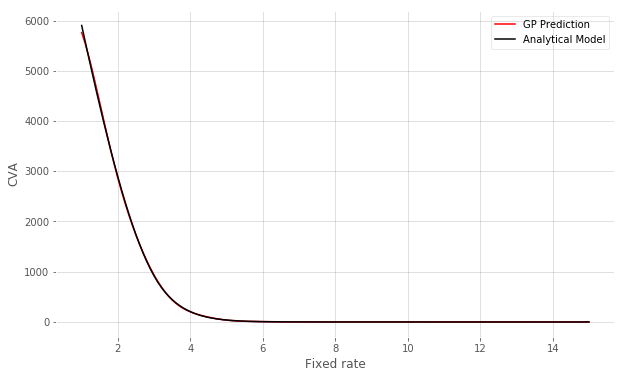

In [255]:
# plot with cov band
up = predict_mean.reshape(len(x),) - 2 * (np.sqrt(np.diag(var)))   # 95% confident interval 
down = predict_mean.reshape(len(x),) + 2 * (np.sqrt(np.diag(var)))

plt.figure(figsize = (10,6), facecolor='white', edgecolor='white')
plt.plot(x_test, predict_mean, color = 'red', label = 'GP Prediction')
plt.plot( x_test, y_test, color = 'black', label = 'Analytical Model')
#plt.scatter(x_train,y_train, s = 150, color = 'black', marker = "+")
plt.fill_between(x*100, up, down, color = 'blue', alpha=0.3)
plt.grid(True, color = 'grey', alpha = 0.3)
#plt.ylim(-1000, 6100)
plt.xlabel('Fixed rate')
plt.ylabel('CVA')
plt.legend(loc = 'best', prop={'size':10})

In [188]:
np.min(np.diag(var))

6.775275962489502e-08

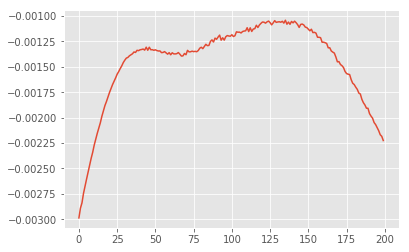

In [189]:
plt.plot(up-down)